In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from polynomial_nets import CP_L3

from poly_GAN import Generator_CP_L3, Critic_CP_L3, Generator_NCP_L3, Generator_CP_C3, Discriminator32, gradient_penalty, gradient_penalty_C, initialize_weights, Generator_attention
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pandas as pd
from torch.utils.tensorboard import SummaryWriter

#from Cuda import DeviceDataLoader

In [29]:
torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 32
CHANNELS_IMG = 1
Z_DIM = 200
NUM_EPOCHS = 5
FEATURES_DISC = 28
FEATURES_GEN = 28
CRITIC_ITERATIONS = 3
#WEIGHT_CLIP = 0.01
LAMBDA_GP = 10
RANK_CRITIC = 200
RANK_GEN = 1600
LHP = 500

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range (CHANNELS_IMG)]),
        
    ]
)

In [30]:
dataset = datasets.MNIST(root='data', train=True, download=True, transform=Compose([transforms.Resize(32), ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [31]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [32]:
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator_attention(Z_DIM, IMAGE_SIZE*IMAGE_SIZE, RANK_GEN).to(device)
#gen = Generator_CP_L3(Z_DIM, IMAGE_SIZE*IMAGE_SIZE, RANK_GEN).to(device)
#critic = Critic_CP_L3(IMAGE_SIZE*IMAGE_SIZE, RANK_CRITIC).to(device)
critic = Discriminator32(CHANNELS_IMG, IMAGE_SIZE).to(device)
initialize_weights(gen)
initialize_weights(critic)

In [33]:
num_param = []
for name, param in gen.named_parameters():
    num = torch.numel(param)
    num_param.append(num)

In [34]:
torch.sum(torch.tensor(num_param))

tensor(2599424)

In [35]:
#input_test = torch.randn((2, 1, 28, 28)).to(device)
#out_test = critic(input_test)

In [9]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

In [36]:

#criterion = nn.BCELoss()
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        #real = real.reshape(-1, IMAGE_SIZE*IMAGE_SIZE) 
        real = real.to(device)
        #print(real.shape)


        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn((real.shape[0], Z_DIM)).to(device)
            #noise_C3 = torch.randn((real.shape[0], Z_DIM, 1, 1)).to(device)
            fake = gen(noise)
            #fake_C3 = gen(noise_C3)
            fake = fake.reshape(-1, 1, IMAGE_SIZE, IMAGE_SIZE) 
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty_C(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP*gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            #for p in critic.parameters():
                #p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        ### Train Generator: min -E[critic(gen_fake)]
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()


    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]  \ Loss D: {loss_critic: .4f}, loss G: {loss_gen: .4f}")

Epoch [1/5]  \ Loss D:  239.7072, loss G:  0.0303
Epoch [2/5]  \ Loss D:  340.1609, loss G:  0.0299
Epoch [3/5]  \ Loss D:  353.8893, loss G:  0.0295
Epoch [4/5]  \ Loss D:  311.3914, loss G:  0.0277
Epoch [5/5]  \ Loss D:  311.6411, loss G:  0.0301


In [37]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [38]:
input = torch.randn(64, Z_DIM).to(device)
fake = gen(input)

In [39]:
fake = fake.reshape(-1, 1, IMAGE_SIZE, IMAGE_SIZE).to('cpu')
denorm_fake = denorm(fake)

In [40]:
torch.min(denorm_fake)

tensor(0.4598, grad_fn=<MinBackward1>)

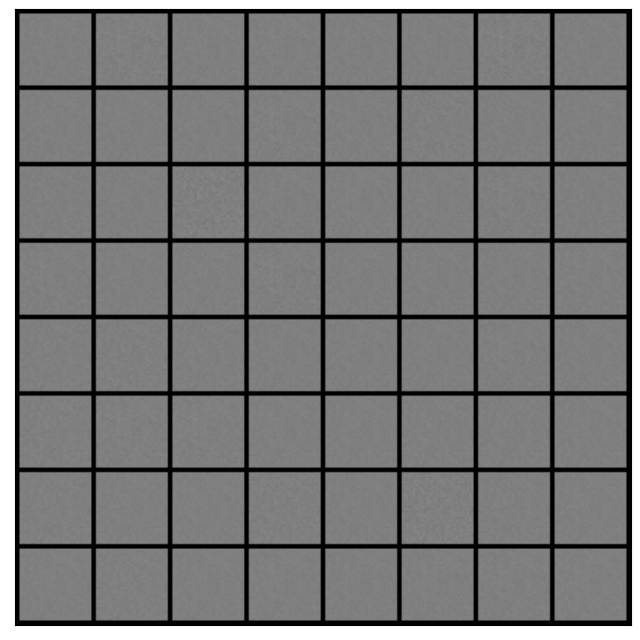

In [41]:
show_images(denorm_fake)


In [42]:
x = torch.randn((2, 3, 28, 28)).to(device)
z = x.squeeze(-1)